In [2]:
import pandas as pd
import numpy as np
import utils
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score, roc_curve, auc
import itertools
import json

In [3]:
pred_prefix = "../ss/iWildCam_"
target_prefix = "../ss/target_iWildCam_"
unc_out_prefix = "ss/unc_"
pred_out_prefix = "ss/pred_"
num_classes = 182
test_sets=["ind","ood"]

Resnet18_ls = ["Resnet18ft0", "Resnet18ft2", "Resnet18ft3"] #, "Resnet18ft3", "Resnet18ft4"
Resnet34_ls = ["Resnet34ft0", "Resnet34ft1"]
Resnet50_ls = ["Resnet50ft0","Resnet50ft2"]
Resnet101_ls = ["Resnet101ft0","Resnet101ft1"]
Resnet152_ls = ["Resnet152ft0"]

S_model_ls = Resnet50_ls
M_model_ls = Resnet101_ls
L_model_ls = Resnet152_ls

val_prefix = "ind"

In [4]:
with open(f"{pred_out_prefix}predictor_categories.json", "r") as file:
    predictor_categories = json.load(file)
print(json.dumps(predictor_categories, indent=2))

{
  "S": [
    "Resnet18ft0",
    "Resnet18ft2",
    "Resnet18ft3"
  ],
  "M": [
    "Resnet50ft0",
    "Resnet50ft2"
  ],
  "L": [
    "Resnet101ft0",
    "Resnet101ft1"
  ],
  "SM_duo": [
    "SM_duo_Resnet18ft0_Resnet50ft0",
    "SM_duo_Resnet18ft0_Resnet50ft2",
    "SM_duo_Resnet18ft2_Resnet50ft0",
    "SM_duo_Resnet18ft2_Resnet50ft2",
    "SM_duo_Resnet18ft3_Resnet50ft0",
    "SM_duo_Resnet18ft3_Resnet50ft2"
  ],
  "SL_duo": [
    "SL_duo_Resnet18ft0_Resnet101ft0",
    "SL_duo_Resnet18ft0_Resnet101ft1",
    "SL_duo_Resnet18ft2_Resnet101ft0",
    "SL_duo_Resnet18ft2_Resnet101ft1",
    "SL_duo_Resnet18ft3_Resnet101ft0",
    "SL_duo_Resnet18ft3_Resnet101ft1"
  ],
  "ML_duo": [
    "ML_duo_Resnet50ft0_Resnet101ft0",
    "ML_duo_Resnet50ft0_Resnet101ft1",
    "ML_duo_Resnet50ft2_Resnet101ft0",
    "ML_duo_Resnet50ft2_Resnet101ft1"
  ]
}


member_smaller='Resnet18ft0' || member_larger='Resnet50ft0'


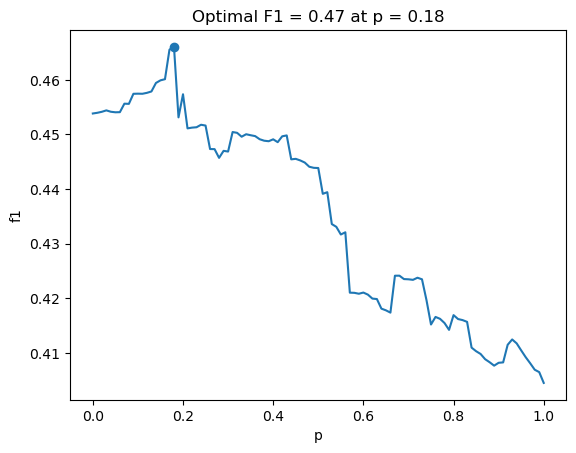

member_smaller='Resnet18ft0' || member_larger='Resnet50ft2'


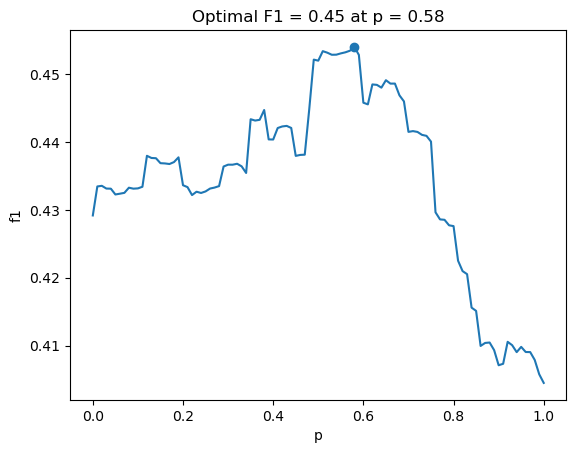

member_smaller='Resnet18ft2' || member_larger='Resnet50ft0'


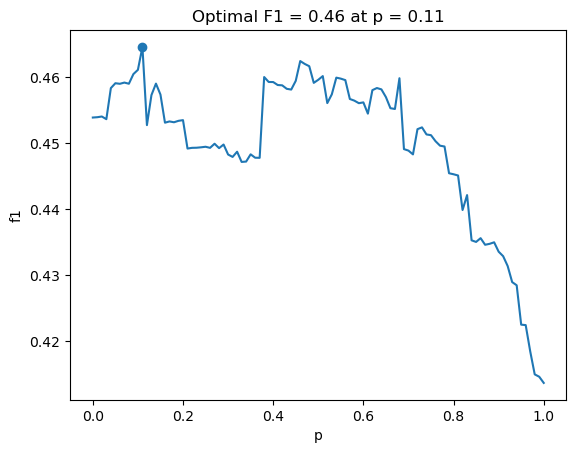

member_smaller='Resnet18ft2' || member_larger='Resnet50ft2'


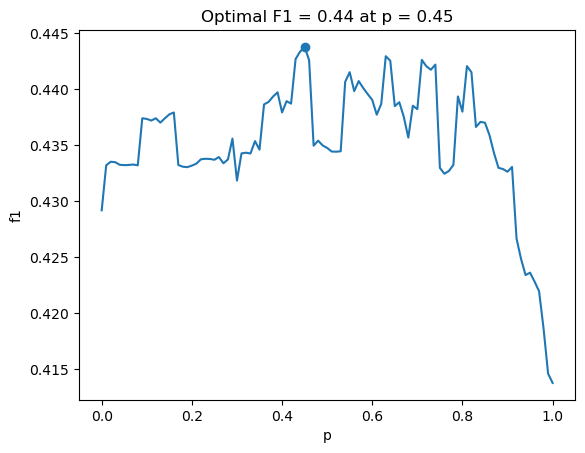

member_smaller='Resnet18ft3' || member_larger='Resnet50ft0'


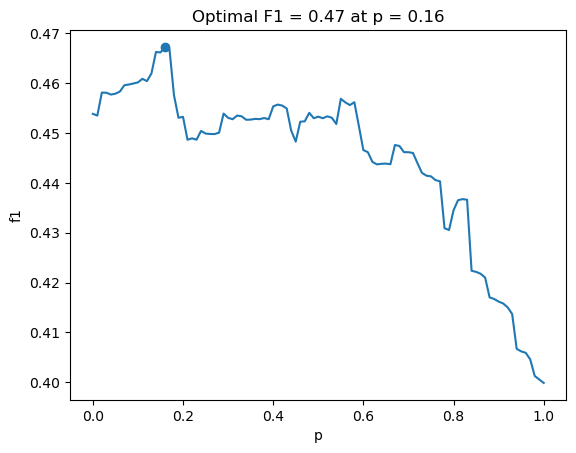

member_smaller='Resnet18ft3' || member_larger='Resnet50ft2'


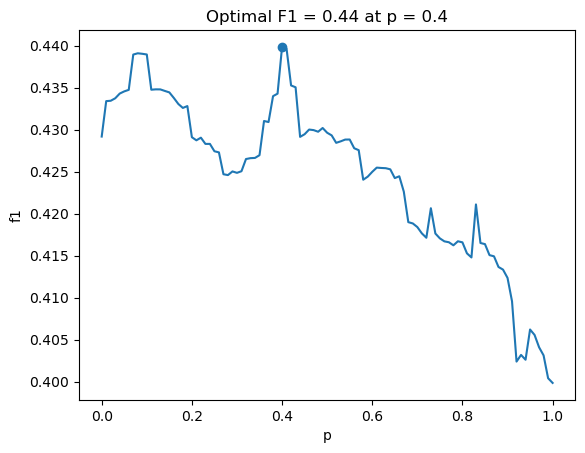

In [30]:
opt_weight_for_duo = {
    "duo":[],
    "p":[]
}
label = pd.read_csv(f"{target_prefix}{val_prefix}.csv")
for duo in predictor_categories["SM_duo"]:
    member_smaller, member_larger = duo.split("_")[2:]
    print(f"{member_smaller=} || {member_larger=}")
    pred_smaller = pd.read_csv(f"{pred_prefix}{val_prefix}_{member_smaller}.csv")
    pred_larger = pd.read_csv(f"{pred_prefix}{val_prefix}_{member_larger}.csv")
    temp_f1_df = {
        "p": [],
        "f1": []
    }
    for p in np.arange(0,1.01,0.01):
        weighted_pred = (p*pred_smaller + (1-p)*pred_larger).idxmax(axis=1).str.extract('(\d+)').astype(int)
        curr_f1 = f1_score(label["target"], weighted_pred, average='macro')
        temp_f1_df["p"].append(p)
        temp_f1_df["f1"].append(curr_f1)
    f1_df = pd.DataFrame(temp_f1_df)
    sns.lineplot(f1_df,x="p",y="f1")
    opt_f1_index = f1_df["f1"].argmax()
    opt_f1 = f1_df["f1"][opt_f1_index]
    opt_p = f1_df["p"][opt_f1_index]
    plt.title(f"Optimal F1 = {opt_f1:.2f} at p = {opt_p}")
    plt.scatter(x=opt_p,y=opt_f1)
    plt.show()
    opt_weight_for_duo["duo"].append(duo)
    opt_weight_for_duo["p"].append(opt_p)
opt_duo_weight_df = pd.DataFrame(opt_weight_for_duo)

In [31]:
display(opt_duo_weight_df)

,duo,p
0,SM_duo_Resnet18ft0_Resnet50ft0,0.18
1,SM_duo_Resnet18ft0_Resnet50ft2,0.58
2,SM_duo_Resnet18ft2_Resnet50ft0,0.11
3,SM_duo_Resnet18ft2_Resnet50ft2,0.45
4,SM_duo_Resnet18ft3_Resnet50ft0,0.16
5,SM_duo_Resnet18ft3_Resnet50ft2,0.40
